In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [3]:
# parameters = {"width": 10,
#               "height": 10,
#               "N": range(10, 500, 10)}

# batch_run = BatchRunner(MoneyModel,
#                         parameters,
#                         iterations=5,
#                         max_steps=100,
#                         model_reporters={"Gini": compute_gini})
# batch_run.run_all()

In [4]:
class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
    def step(self):
        # The agent's step will go here.
        #print(self.unique_id)
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1
        pass    
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
        self.pos,
        moore=True,
        include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

In [5]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.running = True
        
    # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})
            
    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()

In [6]:
empty_model = MoneyModel(10, 10, 10)
for i in range(2):
    empty_model.step()

In [7]:
%matplotlib inline

(array([ 5.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

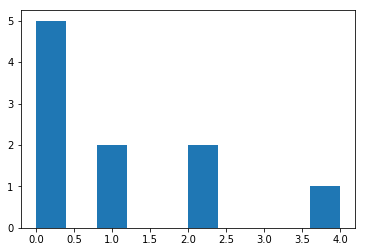

In [8]:
agent_wealth = [a.wealth for a in empty_model.schedule.agents]
plt.hist(agent_wealth)

(array([ 456.,  273.,  152.,   73.,   31.,   11.,    4.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

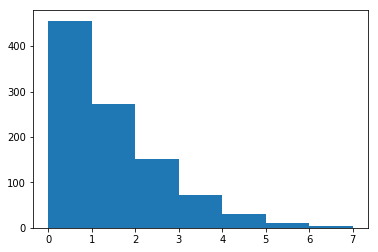

In [9]:
all_wealth = []
for j in range(100):
    
    # Run the model
    model = MoneyModel(10, 10, 10)
    for i in range(10):
        model.step()
        
        # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
        
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

In [10]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

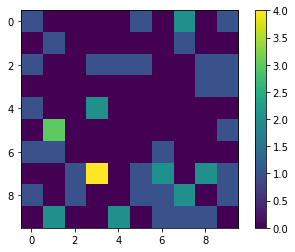

In [11]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

      Gini
0   0.0000
1   0.5760
2   0.6040
3   0.5656
4   0.5856
5   0.5568
6   0.6720
7   0.6216
8   0.6184
9   0.5800
10  0.5640
11  0.5512
12  0.5576
13  0.6008
14  0.6152
15  0.6680
16  0.6320
17  0.6744
18  0.5944
19  0.5824


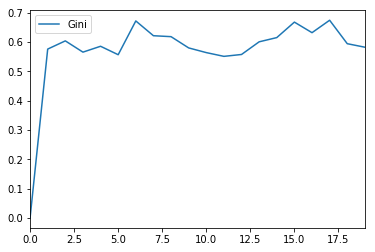

In [12]:
gini = model.datacollector.get_model_vars_dataframe()
print(gini)
gini.plot()

In [13]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Wealth
Step AgentID        
19   45            1
     46            3
     47            1
     48            3
     49            1

In [14]:
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

In [15]:
#agent_wealth

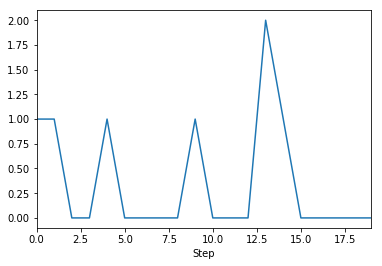

In [16]:
#to plot the wealth of a given agent (in this example, agent 14):
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

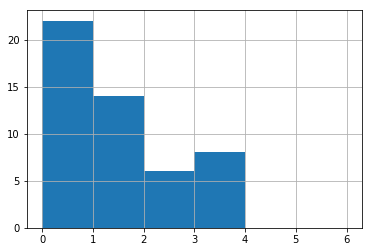

In [17]:
# to get a histogram of agent wealth at the model’s end
end_wealth = agent_wealth.xs(19, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

In [18]:
#run 5 instantiations of the model with each number of agents, and to run each for 100 steps. We have it collect the
#final Gini coefficient value.

parameters = {"width": 10,
              "height": 10,
              "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        parameters,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

100%|██████████| 245/245 [00:13<00:00, 10.29it/s]


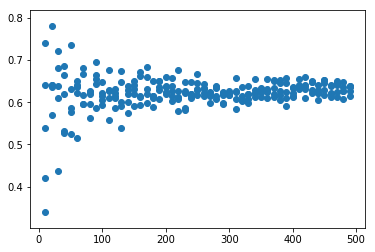

In [19]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)